# Preliminary Study for Open CSV Project

The goal of the Open CSV project is to liberate data that is currently embedded in plots. This notebook is an initial feasibility analysis using modern machine learning methods. To be successful the project will have to do two things: it will have to identify the *locations* and the *value* of the x and y ticks, and it will have to extract the co-ordinates of the data points. 
**This preliminary notebook is focused on the first task only.**

The project has three main components:
1. Generation of a varied training set
2. Creating a varied 'true' (more on that later) validation set
3. Implementing a deep learning method

I will discuss these each in turn.

## Generating a varied training set

To use a deep learning approach, we need an initial training set that is well labelled. Classically, we would rely on a well-funded academic data set like ImageNet or COCO, where thousands of images (plots in our case) are analyzed and labelled by hand. Unfortunately, we don't have access to those resources, so we have to get creative. Luckily, the last few iterations of matplotlib (the python plotting library) have made it fairly easy to create a wide variety of plotting styles and formats (https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html for several nice examples). 

For this initial approach though, we will be just using the standard style library and working on generating random plots.


In [15]:
import numpy as np
import matplotlib.pyplot as plt 
import glob as glob
%matplotlib notebook
%matplotlib notebook

The following cell will generate a random plot, with a randomish amount of noise. 

<IPython.core.display.Javascript object>


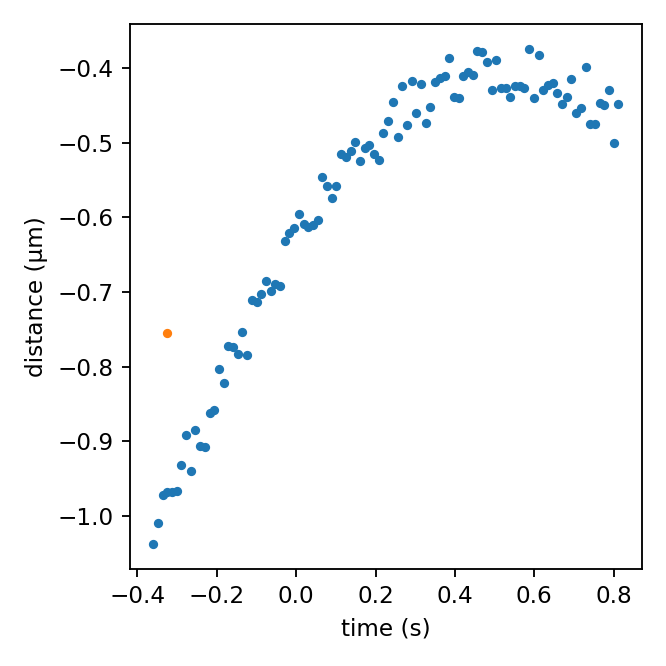

In [11]:
    #np.random.seed(42)
    dpi = 100
    width = 4
    height = 4
    width_px = width * dpi
    height_px = height * dpi
    leading_degree = np.random.randint(low=1, high=5)
    poly = np.random.uniform(low=-1, high = 1, size=leading_degree)

    x_random = np.linspace(*np.random.random(1)*-1, *np.random.random(1), 100)
    y_random = np.polyval(poly, x_random)
    y_random = y_random + y_random.max()/np.random.randint(100)*np.random.uniform(low=-1, high=1, size=100)

    fig, ax = plt.subplots(figsize=(width,height), dpi=dpi)
    ax.plot(x_random, y_random, '.')
    ax.set_ylabel(u'distance (\u00b5m)')
    ax.set_xlabel(u'time (s)')
    plt.tight_layout()
    fig.canvas.draw()
    red_point =[100,200]
    red_point = ax.transData.inverted().transform(red_point)
    ax.plot(red_point[0], red_point[1], '.')

    #fig.savefig(name+'.png',dpi=100)


Now that we have a random image, we need to work on labelling it. For this notebook, I will be solely concered with identifying the location of the tick marks. As an aside, this was actually the most difficult part of the project so far-- extracting the appropriately scaled bounding box for each tick. The following code will do that, and create the metadata in a format that can be used by YOLO, an object detection deep learning algorithm. 

In [14]:
    #need to get and extract metadata for training from matplotlib objects
    x_tick_labels = ax.get_xticklabels()[1:-1]

    y_tick_labels = ax.get_yticklabels()[1:-1]
    meta_data = {
            'x_tick_text' : [tick.get_text() for tick in x_tick_labels],
            'x_tick_display_pos' : [tick._get_xy_display().tolist() for tick in x_tick_labels],
            'x_tick_window'      :[tick.get_window_extent().get_points().tolist() for tick in x_tick_labels],
            'y_tick_text' : [tick.get_text() for tick in y_tick_labels],
            'y_tick_display_pos' : [tick._get_xy_display().tolist() for tick in y_tick_labels],
                'y_tick_window'      :[tick.get_window_extent().get_points().tolist() for tick in y_tick_labels],
                'x'       : list(x_random),
                'y'       : list(y_random)
        }

    #create annotations for yolov3 in format: label_idx x_center y_center width height
    height_px, width_px = fig.get_size_inches()*fig.dpi
    x_anna = np.array(meta_data['x_tick_window']).reshape((len(meta_data['x_tick_window']),4))
    x_anna = np.c_[np.zeros(len(meta_data['x_tick_window'])),x_anna] 

    y_anna = np.array(meta_data['y_tick_window']).reshape((len(meta_data['y_tick_window']),4))
    y_anna = np.c_[np.ones(len(meta_data['y_tick_window'])),y_anna]	
    anna = np.r_[x_anna, y_anna]
    annote_transform = lambda x: (x[0], (x[1]+x[3]/2-x[1]/2)/height_px, 
                                  (x[2]+x[4]/2-x[2]/2)/width_px, (x[3]-x[1])/height_px, (x[4]-x[2])/width_px)
    anna_yolo = np.apply_along_axis(annote_transform,1, anna)
    #np.savetxt('test'+'.txt', anna_yolo, delimiter=' ')

Several specifics need to be discussed, these are all due to matplotlibs 'quirks'. The first is the trucated range on the x_tick_label variable. This is because the first and last tick value that matplotlib stores is not displayed (probably due to a resizing that happens somewhere along the pipeline). 

The second is the _get_xy_display() function. The first way I approached this is by querying the tick locations using the positions function directly on the tick Text object. However, this returns the x, y location in the *data* coordinate system. To be useful to object detection, we need pixel values. Looking at the transformations tutorial on matplotlib (https://matplotlib.org/tutorials/advanced/transforms_tutorial.html), you can use the function ax.transData.transform() to take data x,y coordinates to display coordinates. However, because of the way matplotlib handles the axis, it always lies on the origin (ie. the data coordinate for an x-axis tick would be x, y=0). And when you pass 0 to the transform function it freaks out and seems to have an overflow error. So, I basically just played around until I found the _get_xy_position, which returns a bounding box. 

The rest of the code is to get the bounding box from matplotlib's format (x0,y0,x1,y1) to yolo's format (x_center, y_center, x_width, y_width).

In [13]:
anna_yolo

array([[0.        , 0.20623515, 0.10413889, 0.0841875 , 0.0345    ],
       [0.        , 0.32529868, 0.10413889, 0.084375  , 0.0345    ],
       [0.        , 0.44436221, 0.10413889, 0.0549375 , 0.0345    ],
       [0.        , 0.56342574, 0.10413889, 0.0553125 , 0.0345    ],
       [0.        , 0.68248927, 0.10413889, 0.055125  , 0.0345    ],
       [0.        , 0.8015528 , 0.10413889, 0.055125  , 0.0345    ],
       [0.        , 0.92061633, 0.10413889, 0.055125  , 0.0345    ],
       [1.        , 0.12835764, 0.2213088 , 0.0841875 , 0.0345    ],
       [1.        , 0.12835764, 0.33327007, 0.0841875 , 0.0345    ],
       [1.        , 0.12835764, 0.44523134, 0.0841875 , 0.0345    ],
       [1.        , 0.12835764, 0.55719261, 0.0841875 , 0.0345    ],
       [1.        , 0.12835764, 0.66915388, 0.0841875 , 0.0345    ],
       [1.        , 0.12845139, 0.78111515, 0.084     , 0.0345    ],
       [1.        , 0.12835764, 0.89307642, 0.0841875 , 0.0345    ]])

anna_yolo has the following array structure: [class_idx, x_center, y_center, x_width, y_width], where the x and y values have been scaled by the total size of the image. The class_idx value is to seperate the x and y tick values (although after doing it this way, I no longer think this is neccesary).

You can use these methods to generate a series of random plots, and then run object detection on them to see how well it works. The following results from training YOLOv3 for 100 epochs, starting from weights that were pretrained on ImageNet.

In [17]:
outputPlots = glob.glob("yolov3/output/*.png")


['yolov3/output\\plt0.png',
 'yolov3/output\\plt1.png',
 'yolov3/output\\plt2.png',
 'yolov3/output\\plt3.png',
 'yolov3/output\\plt4.png',
 'yolov3/output\\plt5.png',
 'yolov3/output\\plt6.png',
 'yolov3/output\\plt7.png',
 'yolov3/output\\plt8.png',
 'yolov3/output\\plt9.png']

<IPython.core.display.Javascript object>


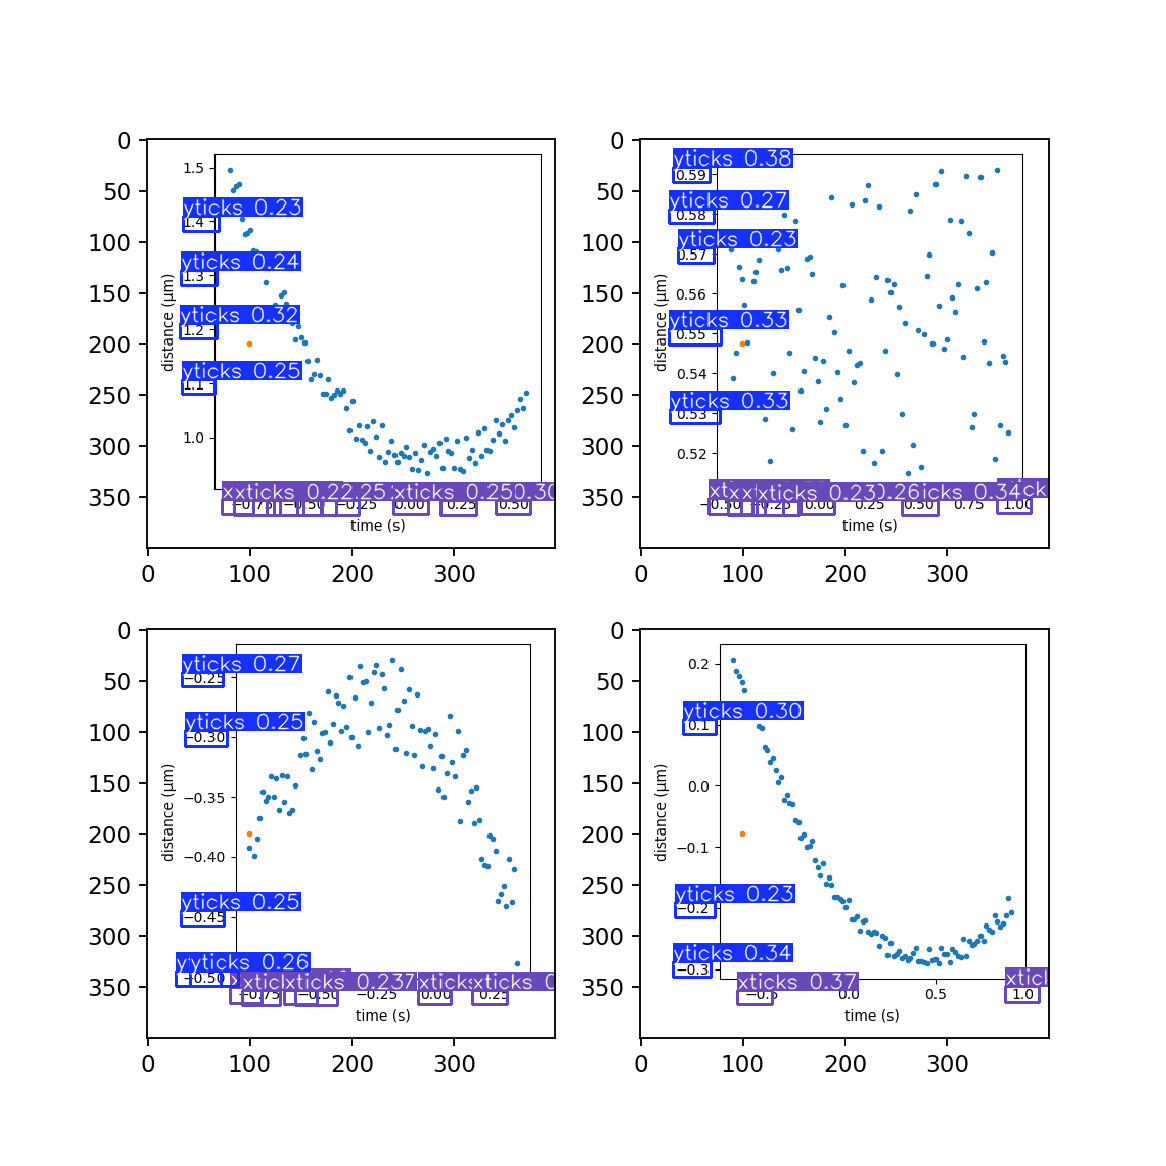

In [29]:
fig = plt.figure(figsize=(7,7))
index = 1
for name in outputPlots[:4]:
    im = plt.imread(name)
    ax = fig.add_subplot(2, 2, index)
    ax.imshow(im)
    index = index+1

Interestingly, YOLO seems much better at detecting yticks. It has a hard time understanding how the x-ticks are grouped, and tends to splits them apart. As well, there are dead-zones around the axis labels, and I am not sure why that is the case. It might be that the bounding boxes as drawn are overlapping/skewing the training for things in that area. 

Several improvements can already be proposed: instead of trying to keep sequence of numbers that define a tick label group, we can have yolo attempt to locate and classify every number present. Because of the structure implicit in a plot, the coordinates of those numbers can then be compared to determine whether they are a y-tick or an x-tick. 

Luckily, because of the regular layout of the plot ticks, *only* two solid identifications of tick labels per axis need to be made, which makes this problem significantly easier. Once the identification has been made, the tick label can then be further processed to 